### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH, FOREX_DATA_PATH_1HR, FOREX_DATA_PATH_15MIN, FOREX_DATA_PATH_5MIN
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import fx_rl
from datetime import datetime, timedelta
import pytz

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

## Latest Data

In [2]:
now = datetime.now()
current_time = pd.to_datetime(now) + timedelta(hours=7)
current_time = current_time.replace(tzinfo=pytz.UTC)
# date_15min = fx_rl.bars_back(current_time, 'M15')
# date_5min = fx_rl.bars_back(current_time, 'M5')
date_1hr = fx_rl.bars_back(current_time, 'H1', total_bars=50_000)


In [3]:
sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=False,
)
sim.download_data(
    symbols=['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD'],
    time_range=(
        date_1hr,
        current_time
    ),
    timeframe=Timeframe.H1
)
sim.save_symbols(FOREX_DATA_PATH)
# sim.save_symbols(f'symbols_forex_15min_{date_1hr.date()}_{current_time.date()}.pkl')

In [4]:
# with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
#     symbols_5min = pickle.load(f)
# # convert symbols_5min to a pd.dataframe
# symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
# max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [5]:
# with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
#     symbols_15min = pickle.load(f)
# # convert symbols_15min to a pd.dataframe
# symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
# max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [6]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [7]:
# # unpack the pickle file and load the data that is in symbols_forex.pkl
# with open(FOREX_DATA_PATH, 'rb') as f:
#     symbols = pickle.load(f)
# # convert symbols to a pd.dataframe
# # symbols[1]['EURUSD']

In [8]:
# slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=True)
# slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=True)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [9]:
# class MyMtEnv(gym_mtsim.MtEnv):
#     # _get_modified_volume = fx_rl.my_get_modified_volume
#     _get_prices = fx_rl.my_get_prices

In [10]:
sim_train_1hr = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH_1HR
)

env_train_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_train_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
# sim_train_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_train_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [12]:
# sim_train_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_train_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [13]:
sim_validation_1hr = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_validation_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
# sim_validation_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_validation_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [15]:
# sim_validation_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_validation_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [16]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MyMtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[2],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [17]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [18]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    # 'timeframe': hp.choice('timeframe', ['5min', '15min', '1hr'])
}

In [19]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error: {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        # avg_reward = np.mean(reward_over_validations)
        # avg_orders = np.mean(orders_over_validations)
        # avg_profit = np.mean(profit_over_validations)
        # print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    if np.mean(profit_over_validations) > 0:
        model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

In [20]:
import os
# create a folder with the name of the date
os.makedirs(f'models_{max_date_1hr.date()}', exist_ok=True)

## Objective Function

In [26]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
step_key = 0
timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 250 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#
    global step_key

    # timeframe = params['timeframe']
    # if timeframe == '5min':
    #     env_train = env_train_5min
    #     env_validation = env_validation_5min
    # elif timeframe == '15min':
    #     env_train = env_train_15min
    #     env_validation = env_validation_15min
    # elif timeframe == '1hr':
    #     env_train = env_train_1hr
    #     env_validation = env_validation_1hr

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key += 1
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    # plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train_1hr, env_validation_1hr, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        if 'Tensor of shape' in str(e):
            print(f'''there was an error with the tensor with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        else:
            print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
                ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(profits, 'Profits')
    print_stats(orders, 'Orders')
    # label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    # plot_data[plot_key] = rewards
    # plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['rewards'] = np.mean(rewards)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [22]:
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     # 'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [23]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [27]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.03871344218927514, learning rate: 0.004380108486785739, gamma: 0.9529776182435414
Min. Profits          :   -569.657                     
Avg. Profits          :     92.304                     
Max. Profits          :    768.769                     
Min. Orders          :     11.000                      
Avg. Orders          :     18.800                      
Max. Orders          :     26.000                      
--------------------------------------------------------------------------------     
entropy: 0.0029998599587874987, learning rate: 0.0020201649269907087, gamma: 0.9508195202921791
Min. Profits          :   -479.704                                                   
Avg. Profits          :   -257.976                                                   
Max. Profits          :    -24.804                                                   
Min. Orders          :     38.000                 

In [28]:
# # make a sound when the code is done
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [29]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': -92.30402874192086, 'status': 'ok', 'eval_time': 1717199019.9792008, 'parameters': {'ent_coef': 0.03871344218927514, 'gamma': 0.9529776182435414, 'learning_rate': 0.004380108486785739, 'avg_orders': 18.8, 'rewards': 0.2939176229814585}}


In [30]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,-92.304029,ok,0.004380,0.038713,0.952978,18.8,0.293918
1,257.976270,ok,0.002020,0.003000,0.950820,49.2,-0.193508
2,NaN,fail,0.030744,0.048305,0.932893,0.0,0.000000
3,-95.333459,ok,0.011882,0.027385,0.926997,37.8,0.062853
4,-55.366002,ok,0.028413,0.017250,0.937869,38.6,0.024701
...,...,...,...,...,...,...,...
245,-56.656362,ok,0.015118,0.029968,0.937185,38.9,0.049225
246,46.403544,ok,0.006634,0.027253,0.929300,39.5,-0.040739
247,-19.320224,ok,0.011553,0.024832,0.944613,39.0,0.019613
248,-78.811921,ok,0.017228,0.011336,0.925003,38.3,0.067860


In [31]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
37,-498.694165,ok,0.000355,0.024114,0.937482,33.5,0.654406
46,-422.721683,ok,0.000165,0.024029,0.930740,30.1,0.489592
170,-414.455551,ok,0.001399,0.027138,0.940065,8.1,1.890361
47,-402.254250,ok,0.000071,0.024613,0.928747,24.8,0.665328
217,-376.473297,ok,0.003003,0.014387,0.929805,60.9,0.271357
...,...,...,...,...,...,...,...
18,-1.182936,ok,0.006026,0.031949,0.973913,39.6,0.001189
102,-1.068034,ok,0.001836,0.033219,0.938754,0.3,-0.300000
216,-1.023745,ok,0.004587,0.034742,0.942355,40.8,-0.003314
48,-0.617467,ok,0.005655,0.014802,0.945981,45.8,0.041890


In [32]:
total_learning_timesteps = 250 * 1_000

In [33]:
custom_palette = sns.color_palette(["red", "green"])

In [34]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [35]:
# find all of the models that are in the /models_2024_05_17 folder
folder_path = f'C:/Users/WilliamFetzner/Documents/Trading/models_{max_date_1hr.date()}'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_100_2024-05-31.pkl'

In [36]:
file_list

['model_100_2024-05-31.pkl',
 'model_102_2024-05-31.pkl',
 'model_103_2024-05-31.pkl',
 'model_104_2024-05-31.pkl',
 'model_105_2024-05-31.pkl',
 'model_106_2024-05-31.pkl',
 'model_111_2024-05-31.pkl',
 'model_114_2024-05-31.pkl',
 'model_115_2024-05-31.pkl',
 'model_116_2024-05-31.pkl',
 'model_117_2024-05-31.pkl',
 'model_119_2024-05-31.pkl',
 'model_11_2024-05-31.pkl',
 'model_120_2024-05-31.pkl',
 'model_121_2024-05-31.pkl',
 'model_123_2024-05-31.pkl',
 'model_125_2024-05-31.pkl',
 'model_127_2024-05-31.pkl',
 'model_129_2024-05-31.pkl',
 'model_12_2024-05-31.pkl',
 'model_130_2024-05-31.pkl',
 'model_132_2024-05-31.pkl',
 'model_133_2024-05-31.pkl',
 'model_136_2024-05-31.pkl',
 'model_137_2024-05-31.pkl',
 'model_138_2024-05-31.pkl',
 'model_139_2024-05-31.pkl',
 'model_13_2024-05-31.pkl',
 'model_140_2024-05-31.pkl',
 'model_143_2024-05-31.pkl',
 'model_144_2024-05-31.pkl',
 'model_145_2024-05-31.pkl',
 'model_147_2024-05-31.pkl',
 'model_148_2024-05-31.pkl',
 'model_150_2024-

In [37]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [38]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0
    print_stats(rewards, 'Profits')
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


1it [01:37, 97.82s/it]

Min. Profits          :   -917.033
Avg. Profits          :    -69.891
Max. Profits          :   1772.400


2it [03:17, 99.15s/it]

Min. Profits          :   -939.911
Avg. Profits          :    -79.276
Max. Profits          :   2567.276
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

3it [04:30, 86.86s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -253.605
Avg. Profits          :      0.285
Max. Profits          :    391.032


4it [06:10, 92.06s/it]

Min. Profits          :  -1033.021
Avg. Profits          :    -67.209
Max. Profits          :   1675.207


5it [07:47, 93.89s/it]

Min. Profits          :   -731.040
Avg. Profits          :    255.706
Max. Profits          :   1898.625


6it [09:28, 96.30s/it]

Min. Profits          :  -1014.667
Avg. Profits          :    -62.971
Max. Profits          :   2557.055


7it [11:08, 97.44s/it]

Min. Profits          :   -968.480
Avg. Profits          :    -84.463
Max. Profits          :   1649.345


8it [12:47, 98.12s/it]

Min. Profits          :   -961.570
Avg. Profits          :    -64.896
Max. Profits          :   1637.420


9it [14:26, 98.38s/it]

Min. Profits          :   -969.482
Avg. Profits          :   -101.899
Max. Profits          :   1804.469


10it [16:07, 99.01s/it]

Min. Profits          :   -933.337
Avg. Profits          :    -98.518
Max. Profits          :   1583.210


11it [17:46, 99.23s/it]

Min. Profits          :   -982.297
Avg. Profits          :    -95.966
Max. Profits          :   2159.011


12it [19:27, 99.70s/it]

Min. Profits          :  -1891.451
Avg. Profits          :   -206.422
Max. Profits          :   1840.271


13it [21:07, 99.70s/it]

Min. Profits          :   -910.134
Avg. Profits          :    -94.826
Max. Profits          :   2404.670


14it [22:45, 99.41s/it]

Min. Profits          :  -1248.768
Avg. Profits          :   -129.841
Max. Profits          :   2030.245


15it [24:44, 105.08s/it]

Min. Profits          :   -914.195
Avg. Profits          :    -76.976
Max. Profits          :   1678.188


16it [26:48, 110.93s/it]

Min. Profits          :  -1667.509
Avg. Profits          :    -67.503
Max. Profits          :   2237.793


17it [28:45, 112.75s/it]

Min. Profits          :   -917.480
Avg. Profits          :    -69.460
Max. Profits          :   1859.050


18it [30:35, 111.95s/it]

Min. Profits          :  -1670.980
Avg. Profits          :     86.303
Max. Profits          :   2321.828


19it [32:32, 113.32s/it]

Min. Profits          :  -1082.701
Avg. Profits          :    -99.927
Max. Profits          :   1693.977


20it [34:38, 117.15s/it]

Min. Profits          :  -2219.432
Avg. Profits          :    245.761
Max. Profits          :   3536.868


21it [36:39, 118.31s/it]

Min. Profits          :   -972.094
Avg. Profits          :    -85.094
Max. Profits          :   1722.825


22it [38:36, 118.01s/it]

Min. Profits          :   -965.335
Avg. Profits          :    -61.024
Max. Profits          :   2425.991


23it [40:35, 118.33s/it]

Min. Profits          :   -955.963
Avg. Profits          :    -76.075
Max. Profits          :   2037.151


24it [42:34, 118.37s/it]

Min. Profits          :   -960.472
Avg. Profits          :    -99.029
Max. Profits          :   1788.786


25it [44:32, 118.37s/it]

Min. Profits          :   -911.032
Avg. Profits          :    -38.967
Max. Profits          :   1546.332


26it [46:23, 116.21s/it]

Min. Profits          :  -1597.922
Avg. Profits          :    -90.924
Max. Profits          :   2008.562


27it [48:37, 121.53s/it]

Min. Profits          :  -2448.040
Avg. Profits          :    -23.015
Max. Profits          :   2277.191


28it [50:19, 115.62s/it]

Min. Profits          :   -767.551
Avg. Profits          :    -22.223
Max. Profits          :    981.734


29it [52:17, 116.25s/it]

Min. Profits          :   -950.808
Avg. Profits          :    -69.599
Max. Profits          :   1765.823


30it [54:14, 116.65s/it]

Min. Profits          :   -911.825
Avg. Profits          :    -78.304
Max. Profits          :   1531.672


31it [56:12, 116.99s/it]

Min. Profits          :   -947.593
Avg. Profits          :    -53.386
Max. Profits          :   2223.764


32it [58:12, 117.91s/it]

Min. Profits          :  -1522.018
Avg. Profits          :    144.361
Max. Profits          :   2903.124


33it [59:53, 112.66s/it]

Min. Profits          :  -1391.113
Avg. Profits          :    -86.812
Max. Profits          :   1763.106


34it [1:01:25, 106.47s/it]

Min. Profits          :  -1786.335
Avg. Profits          :    -65.761
Max. Profits          :   2210.648


35it [1:02:49, 99.99s/it] 

Min. Profits          :  -1298.929
Avg. Profits          :   -168.954
Max. Profits          :   1079.080


36it [1:04:24, 98.26s/it]

Min. Profits          :  -1471.237
Avg. Profits          :     25.942
Max. Profits          :   2526.507


37it [1:05:56, 96.58s/it]

Min. Profits          :  -1118.439
Avg. Profits          :   -108.874
Max. Profits          :   2443.495


38it [1:07:15, 91.31s/it]

Min. Profits          :   -976.115
Avg. Profits          :    -12.881
Max. Profits          :   2094.815
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

39it [1:08:26, 85.21s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -417.949
Avg. Profits          :      0.394
Max. Profits          :    657.007


40it [1:10:05, 89.30s/it]

Min. Profits          :  -1740.656
Avg. Profits          :     11.320
Max. Profits          :   2480.061


41it [1:11:38, 90.24s/it]

Min. Profits          :  -1729.173
Avg. Profits          :     62.128
Max. Profits          :   2699.302
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

42it [1:12:50, 84.83s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -424.747
Avg. Profits          :     -8.727
Max. Profits          :    744.117


43it [1:14:27, 88.66s/it]

Min. Profits          :  -1545.108
Avg. Profits          :     15.135
Max. Profits          :   2084.616


44it [1:16:07, 92.05s/it]

Min. Profits          :  -1343.531
Avg. Profits          :    -38.680
Max. Profits          :   1420.386


45it [1:17:43, 93.20s/it]

Min. Profits          :   -904.709
Avg. Profits          :    -87.644
Max. Profits          :   1898.508


46it [1:19:23, 95.27s/it]

Min. Profits          :  -1754.115
Avg. Profits          :      5.393
Max. Profits          :   2532.741


47it [1:20:59, 95.48s/it]

Min. Profits          :  -1617.551
Avg. Profits          :     66.355
Max. Profits          :   2371.529


48it [1:22:33, 94.95s/it]

Min. Profits          :   -959.108
Avg. Profits          :    -35.826
Max. Profits          :   2200.159


49it [1:24:10, 95.48s/it]

Min. Profits          :   -920.943
Avg. Profits          :    -63.698
Max. Profits          :   1596.619


50it [1:25:42, 94.62s/it]

Min. Profits          :   -959.193
Avg. Profits          :    -95.569
Max. Profits          :   1698.272


51it [1:27:18, 94.87s/it]

Min. Profits          :   -988.020
Avg. Profits          :    -71.177
Max. Profits          :   2152.088


52it [1:28:56, 95.87s/it]

Min. Profits          :   -949.358
Avg. Profits          :    503.094
Max. Profits          :   3365.228


53it [1:30:31, 95.46s/it]

Min. Profits          :   -903.516
Avg. Profits          :    -76.502
Max. Profits          :   1970.619


54it [1:32:09, 96.40s/it]

Min. Profits          :  -1026.301
Avg. Profits          :    -80.202
Max. Profits          :   1977.650


55it [1:33:45, 96.11s/it]

Min. Profits          :  -1072.751
Avg. Profits          :   -104.804
Max. Profits          :   1621.065


56it [1:35:20, 96.04s/it]

Min. Profits          :   -912.989
Avg. Profits          :    -56.116
Max. Profits          :   1914.061


57it [1:36:57, 96.14s/it]

Min. Profits          :   -975.069
Avg. Profits          :   -108.766
Max. Profits          :   1488.787


58it [1:38:34, 96.35s/it]

Min. Profits          :   -913.109
Avg. Profits          :    -73.481
Max. Profits          :   2356.968


59it [1:40:10, 96.21s/it]

Min. Profits          :  -1032.421
Avg. Profits          :    -74.761
Max. Profits          :   1643.269


60it [1:41:33, 92.42s/it]

Min. Profits          :   -879.872
Avg. Profits          :    123.196
Max. Profits          :   2197.822


61it [1:43:09, 93.46s/it]

Min. Profits          :   -971.767
Avg. Profits          :   -104.163
Max. Profits          :   1926.023


62it [1:44:52, 96.22s/it]

Min. Profits          :  -1274.988
Avg. Profits          :    299.425
Max. Profits          :   2423.135


63it [1:46:28, 96.22s/it]

Min. Profits          :  -1033.905
Avg. Profits          :   -101.764
Max. Profits          :   1600.952


64it [1:48:03, 95.98s/it]

Min. Profits          :   -934.867
Avg. Profits          :    -95.347
Max. Profits          :   1749.864


65it [1:49:40, 96.06s/it]

Min. Profits          :  -1105.775
Avg. Profits          :    -66.849
Max. Profits          :   1848.647


66it [1:51:23, 98.22s/it]

Min. Profits          :  -2406.477
Avg. Profits          :      8.171
Max. Profits          :   3479.092


67it [1:53:01, 98.11s/it]

Min. Profits          :   -970.298
Avg. Profits          :    -95.923
Max. Profits          :   1449.849


68it [1:54:36, 97.24s/it]

Min. Profits          :   -926.388
Avg. Profits          :    -77.893
Max. Profits          :   1714.850
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

69it [1:55:44, 88.59s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -153.315
Avg. Profits          :      2.883
Max. Profits          :    639.507


70it [1:57:20, 90.83s/it]

Min. Profits          :  -1005.385
Avg. Profits          :    -60.685
Max. Profits          :   1399.369


71it [1:58:44, 88.56s/it]

Min. Profits          :   -959.473
Avg. Profits          :    -30.357
Max. Profits          :   1225.139
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'


72it [1:59:58, 84.33s/it]

Min. Profits          :   -589.419
Avg. Profits          :    -28.025
Max. Profits          :    903.810


73it [2:01:33, 87.40s/it]

Min. Profits          :   -953.583
Avg. Profits          :   -106.399
Max. Profits          :   1695.482


74it [2:03:10, 90.48s/it]

Min. Profits          :  -1045.899
Avg. Profits          :    -36.552
Max. Profits          :   1958.074


75it [2:04:45, 91.81s/it]

Min. Profits          :   -990.676
Avg. Profits          :    -61.817
Max. Profits          :   1563.482
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

76it [2:05:57, 85.78s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -461.984
Avg. Profits          :     -7.725
Max. Profits          :    495.235


77it [2:07:32, 88.67s/it]

Min. Profits          :   -968.344
Avg. Profits          :    -91.068
Max. Profits          :   1705.761


78it [2:09:09, 91.00s/it]

Min. Profits          :   -892.449
Avg. Profits          :    -70.993
Max. Profits          :   2485.864


79it [2:10:58, 96.41s/it]

Min. Profits          :   -945.667
Avg. Profits          :    -77.060
Max. Profits          :   1830.814


80it [2:12:33, 95.96s/it]

Min. Profits          :   -986.959
Avg. Profits          :    -69.276
Max. Profits          :   2096.646


81it [2:14:12, 96.82s/it]

Min. Profits          :  -1013.827
Avg. Profits          :   -103.447
Max. Profits          :   1799.966


82it [2:15:47, 96.33s/it]

Min. Profits          :   -931.504
Avg. Profits          :    -76.102
Max. Profits          :   1596.747


83it [2:17:18, 94.71s/it]

Min. Profits          :  -1612.570
Avg. Profits          :     44.628
Max. Profits          :   2135.721


84it [2:18:53, 95.01s/it]

Min. Profits          :   -924.412
Avg. Profits          :    -44.718
Max. Profits          :   1745.291


85it [2:20:31, 95.70s/it]

Min. Profits          :  -1159.080
Avg. Profits          :    -73.992
Max. Profits          :   1694.892


86it [2:22:18, 99.26s/it]

Min. Profits          :  -2747.047
Avg. Profits          :     23.965
Max. Profits          :   2580.934


87it [2:24:00, 99.95s/it]

Min. Profits          :  -2036.915
Avg. Profits          :    -68.226
Max. Profits          :   1853.386


88it [2:25:35, 98.43s/it]

Min. Profits          :   -971.586
Avg. Profits          :    -56.111
Max. Profits          :   1756.984


89it [2:27:11, 97.76s/it]

Min. Profits          :   -919.111
Avg. Profits          :    -84.394
Max. Profits          :   1785.010


90it [2:28:43, 96.01s/it]

Min. Profits          :  -1581.886
Avg. Profits          :    -99.224
Max. Profits          :   2229.136


91it [2:30:29, 99.03s/it]

Min. Profits          :  -1613.044
Avg. Profits          :    -32.418
Max. Profits          :   2606.225


92it [2:31:52, 94.30s/it]

Min. Profits          :  -1151.427
Avg. Profits          :     -5.991
Max. Profits          :   1868.318


93it [2:33:27, 94.55s/it]

Min. Profits          :   -951.494
Avg. Profits          :    -50.654
Max. Profits          :   1753.317


94it [2:34:45, 89.52s/it]

Min. Profits          :   -977.782
Avg. Profits          :    -28.077
Max. Profits          :   1078.845


95it [2:36:15, 89.61s/it]

Min. Profits          :  -1368.451
Avg. Profits          :    -76.346
Max. Profits          :   2206.220


96it [2:37:58, 93.64s/it]

Min. Profits          :  -2156.707
Avg. Profits          :    154.685
Max. Profits          :   3144.760


97it [2:39:33, 94.07s/it]

Min. Profits          :   -944.502
Avg. Profits          :    -84.892
Max. Profits          :   1995.579


98it [2:41:09, 94.64s/it]

Min. Profits          :   -938.975
Avg. Profits          :    -58.364
Max. Profits          :   1777.160


99it [2:42:44, 94.86s/it]

Min. Profits          :   -976.283
Avg. Profits          :    -89.410
Max. Profits          :   1803.019


100it [2:44:20, 95.06s/it]

Min. Profits          :   -981.453
Avg. Profits          :    -47.977
Max. Profits          :   1876.435


101it [2:45:55, 95.12s/it]

Min. Profits          :  -1451.332
Avg. Profits          :    261.195
Max. Profits          :   2621.913


102it [2:47:30, 95.11s/it]

Min. Profits          :   -923.787
Avg. Profits          :    -79.410
Max. Profits          :   2014.267


103it [2:49:07, 95.58s/it]

Min. Profits          :   -920.776
Avg. Profits          :    -85.083
Max. Profits          :   1832.658


104it [2:50:42, 95.47s/it]

Min. Profits          :  -1091.863
Avg. Profits          :    -53.690
Max. Profits          :   1983.668


105it [2:52:18, 95.70s/it]

Min. Profits          :   -930.624
Avg. Profits          :    -95.535
Max. Profits          :   1560.834
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

106it [2:53:33, 89.43s/it]

Min. Profits          :   -452.855
Avg. Profits          :    -19.741
Max. Profits          :    823.187


107it [2:55:09, 91.50s/it]

Min. Profits          :   -930.117
Avg. Profits          :    -69.509
Max. Profits          :   1657.021


108it [2:56:49, 93.81s/it]

Min. Profits          :  -1674.831
Avg. Profits          :    -69.299
Max. Profits          :   2007.104


109it [2:58:24, 94.13s/it]

Min. Profits          :   -970.203
Avg. Profits          :    -86.297
Max. Profits          :   1660.348


110it [2:59:59, 94.67s/it]

Min. Profits          :   -948.518
Avg. Profits          :    -91.224
Max. Profits          :   1547.954


111it [3:01:40, 96.42s/it]

Min. Profits          :  -1821.774
Avg. Profits          :    -50.623
Max. Profits          :   3028.224


112it [3:03:17, 96.45s/it]

Min. Profits          :   -986.906
Avg. Profits          :    -82.129
Max. Profits          :   2722.623


113it [3:05:02, 99.06s/it]

Min. Profits          :  -1972.773
Avg. Profits          :    474.640
Max. Profits          :   3490.245


114it [3:06:38, 98.24s/it]

Min. Profits          :   -908.682
Avg. Profits          :    -88.978
Max. Profits          :   1619.899


115it [3:08:09, 96.21s/it]

Min. Profits          :  -1447.533
Avg. Profits          :   -147.703
Max. Profits          :   2062.071


116it [3:09:44, 95.60s/it]

Min. Profits          :   -927.625
Avg. Profits          :    -81.209
Max. Profits          :   2237.109


117it [3:11:25, 97.27s/it]

Min. Profits          :  -2065.326
Avg. Profits          :    -44.375
Max. Profits          :   2500.018


118it [3:13:01, 96.84s/it]

Min. Profits          :   -930.500
Avg. Profits          :    -64.484
Max. Profits          :   1746.614


119it [3:14:36, 96.38s/it]

Min. Profits          :  -1082.661
Avg. Profits          :    -70.727
Max. Profits          :   1842.338


120it [3:16:20, 98.70s/it]

Min. Profits          :  -1865.114
Avg. Profits          :    419.977
Max. Profits          :   2929.182


121it [3:17:53, 96.92s/it]

Min. Profits          :  -1327.787
Avg. Profits          :    103.905
Max. Profits          :   3550.657


122it [3:19:29, 96.66s/it]

Min. Profits          :  -1811.004
Avg. Profits          :   -134.285
Max. Profits          :   2165.143


123it [3:21:05, 96.38s/it]

Min. Profits          :   -932.072
Avg. Profits          :   -101.267
Max. Profits          :   1485.959


124it [3:22:40, 95.93s/it]

Min. Profits          :  -1426.440
Avg. Profits          :     11.351
Max. Profits          :   1717.134


125it [3:24:17, 96.32s/it]

Min. Profits          :   -921.152
Avg. Profits          :    -90.715
Max. Profits          :   1793.814


126it [3:25:53, 96.35s/it]

Min. Profits          :   -920.032
Avg. Profits          :    -96.117
Max. Profits          :   1565.810


127it [3:27:30, 96.44s/it]

Min. Profits          :   -932.695
Avg. Profits          :    -97.241
Max. Profits          :   1880.490


128it [3:29:06, 96.38s/it]

Min. Profits          :   -961.249
Avg. Profits          :    -67.299
Max. Profits          :   1988.756


129it [3:30:42, 96.15s/it]

Min. Profits          :   -995.107
Avg. Profits          :    -90.137
Max. Profits          :   1727.520


130it [3:32:28, 99.22s/it]

Min. Profits          :  -1461.630
Avg. Profits          :    -61.838
Max. Profits          :   2217.263


131it [3:34:06, 98.94s/it]

Min. Profits          :  -1766.751
Avg. Profits          :     -6.119
Max. Profits          :   1785.417


132it [3:35:42, 97.81s/it]

Min. Profits          :   -914.324
Avg. Profits          :    -81.399
Max. Profits          :   1784.938


133it [3:37:02, 92.46s/it]

Min. Profits          :   -933.741
Avg. Profits          :    -12.558
Max. Profits          :   1766.312


134it [3:38:38, 93.53s/it]

Min. Profits          :  -1124.209
Avg. Profits          :    -62.898
Max. Profits          :   1600.412
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

135it [3:39:53, 88.04s/it]

Min. Profits          :   -617.400
Avg. Profits          :      6.010
Max. Profits          :   1446.279


136it [3:41:28, 90.09s/it]

Min. Profits          :   -954.019
Avg. Profits          :    -99.046
Max. Profits          :   1913.036


137it [3:43:04, 91.87s/it]

Min. Profits          :   -927.733
Avg. Profits          :    -96.071
Max. Profits          :   2023.149


138it [3:44:40, 93.21s/it]

Min. Profits          :  -1270.004
Avg. Profits          :   -146.491
Max. Profits          :   1602.977


139it [3:46:19, 95.07s/it]

Min. Profits          :  -1372.971
Avg. Profits          :    394.242
Max. Profits          :   3048.287


140it [3:47:58, 96.05s/it]

Min. Profits          :  -1651.117
Avg. Profits          :    279.376
Max. Profits          :   3188.028


141it [3:49:34, 96.01s/it]

Min. Profits          :   -926.880
Avg. Profits          :    -96.831
Max. Profits          :   1785.278


142it [3:51:10, 96.07s/it]

Min. Profits          :   -915.926
Avg. Profits          :    -90.480
Max. Profits          :   1548.915
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

143it [3:52:21, 88.71s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -222.012
Avg. Profits          :      1.384
Max. Profits          :    336.777


144it [3:54:02, 92.37s/it]

Min. Profits          :   -967.377
Avg. Profits          :    -90.028
Max. Profits          :   2135.713


145it [3:55:33, 91.82s/it]

Min. Profits          :  -1297.973
Avg. Profits          :      2.522
Max. Profits          :   1522.595
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

146it [3:56:39, 84.21s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -110.204
Avg. Profits          :     -0.053
Max. Profits          :    252.694


147it [3:58:16, 87.92s/it]

Min. Profits          :   -923.874
Avg. Profits          :    -79.641
Max. Profits          :   1668.095


148it [3:59:59, 92.48s/it]

Min. Profits          :   -922.664
Avg. Profits          :    -99.475
Max. Profits          :   1592.420


149it [4:01:35, 93.59s/it]

Min. Profits          :   -935.057
Avg. Profits          :    -90.544
Max. Profits          :   2110.407


150it [4:03:13, 94.89s/it]

Min. Profits          :   -939.164
Avg. Profits          :    -71.032
Max. Profits          :   1906.093


151it [4:04:49, 95.18s/it]

Min. Profits          :   -892.338
Avg. Profits          :    -96.099
Max. Profits          :   1625.139


152it [4:06:25, 95.36s/it]

Min. Profits          :   -903.592
Avg. Profits          :    -64.938
Max. Profits          :   1606.177


153it [4:08:00, 95.42s/it]

Min. Profits          :  -1025.928
Avg. Profits          :   -111.422
Max. Profits          :   1572.231


154it [4:09:37, 95.68s/it]

Min. Profits          :   -928.567
Avg. Profits          :    -69.998
Max. Profits          :   1802.175


155it [4:11:12, 95.64s/it]

Min. Profits          :   -927.525
Avg. Profits          :    -70.308
Max. Profits          :   1672.527


156it [4:12:33, 91.24s/it]

Min. Profits          :  -1067.044
Avg. Profits          :    -22.926
Max. Profits          :   1795.627


157it [4:14:10, 92.81s/it]

Min. Profits          :   -967.194
Avg. Profits          :   -110.698
Max. Profits          :   1728.051


158it [4:15:45, 97.12s/it]

Min. Profits          :   -959.069
Avg. Profits          :    -98.172
Max. Profits          :   1773.316


In [39]:
df = pd.DataFrame(reward_over_tests)
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_100,model_102,model_103,model_104,model_105,model_106,model_111,model_114,model_115,model_116,...,model_89,model_8,model_91,model_92,model_93,model_94,model_95,model_97,model_98,model_9
0,207.173580,-87.880840,NaN,-233.397009,62.697620,-168.698569,1649.345321,-661.241342,-372.414102,649.968701,...,-510.249743,-82.728011,155.256933,300.241791,52.836459,1007.461589,-449.706929,12.942870,-398.964040,-409.299891
1,-262.850504,-36.442038,NaN,-506.214804,227.697402,-649.344923,542.765603,327.512078,-365.132301,-615.647136,...,-880.948365,-570.542157,637.061224,331.950768,-141.784750,99.468612,-368.464054,-449.706717,-360.284638,-234.570491
2,301.481093,518.714666,NaN,-874.209006,513.772888,-551.338119,199.549365,117.193077,-321.639935,-608.174196,...,-152.995895,-913.630873,-96.805889,661.315545,1106.862623,979.755146,204.048250,773.016038,-286.356001,-371.922377
3,596.886900,158.890779,NaN,-506.736861,855.262118,95.709089,328.181086,-427.815865,-579.192119,736.865796,...,268.773551,-368.195084,428.817807,-690.606653,-493.985793,-404.030418,550.835979,-145.098189,-304.037653,271.587615
4,-174.903477,-813.908693,NaN,146.282079,41.274721,-257.999893,-137.167750,-338.188378,842.022869,76.884780,...,481.770763,317.835558,40.993698,-578.223162,80.377707,-575.365182,419.328006,-217.787458,852.166143,325.093836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,871.148714,-123.193011,-13.125738,-252.949785,646.659162,-0.086433,333.306017,-509.838484,-149.037704,-529.933519,...,-458.007597,470.944678,448.231112,-564.026448,414.882173,826.474591,362.743368,-294.094477,-129.458251,-211.097949
996,-509.673132,-299.794497,93.797612,-388.566475,493.071233,1045.852606,-208.914648,296.524003,1446.085910,993.208174,...,-127.682699,515.128534,-653.749898,-581.501142,-904.942590,-568.645098,-244.697018,-8.977182,-592.965876,-668.464293
997,216.046606,-41.740086,NaN,663.067598,404.447216,437.027008,-486.602824,-127.770618,20.061742,-705.500185,...,2110.406998,-642.837561,1103.231957,251.136877,471.980836,-242.652016,-18.887012,93.108414,97.900148,-2.778345
998,32.821613,0.988730,-13.922584,843.409922,114.884338,-720.434437,-188.060852,-844.951750,220.863195,97.525539,...,-491.171514,648.335449,-286.514605,-340.432873,200.537700,-251.801362,-546.399936,-117.071484,-858.122214,898.449491


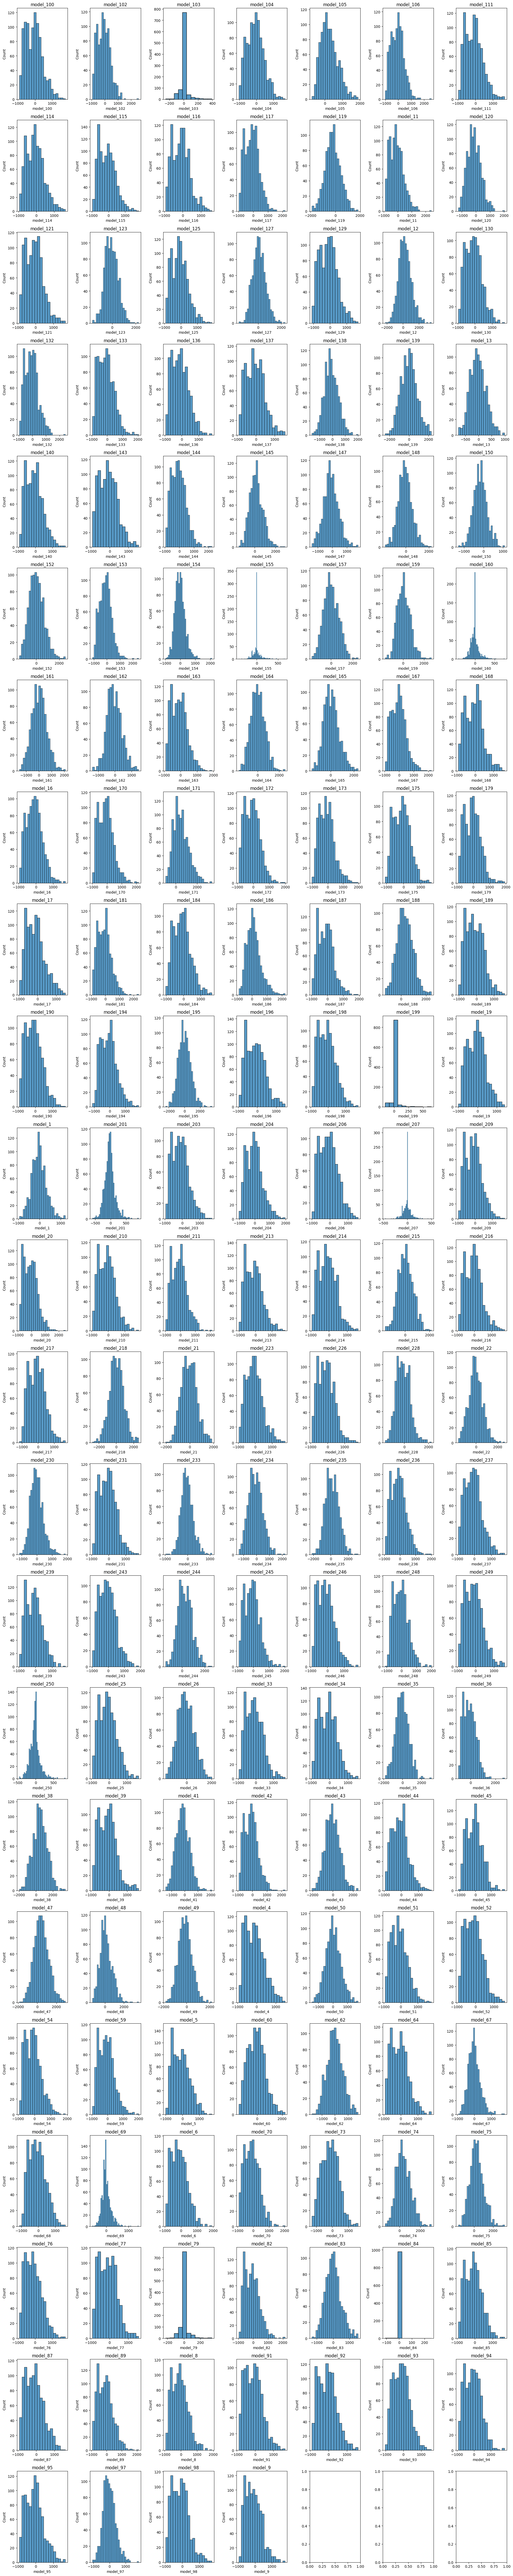

In [43]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=23, ncols=7, figsize=(20, 100))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()